<a href="https://colab.research.google.com/github/ajay47847/pcg_classification/blob/main/crossValAllFreqAllPointStftSvm(74%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


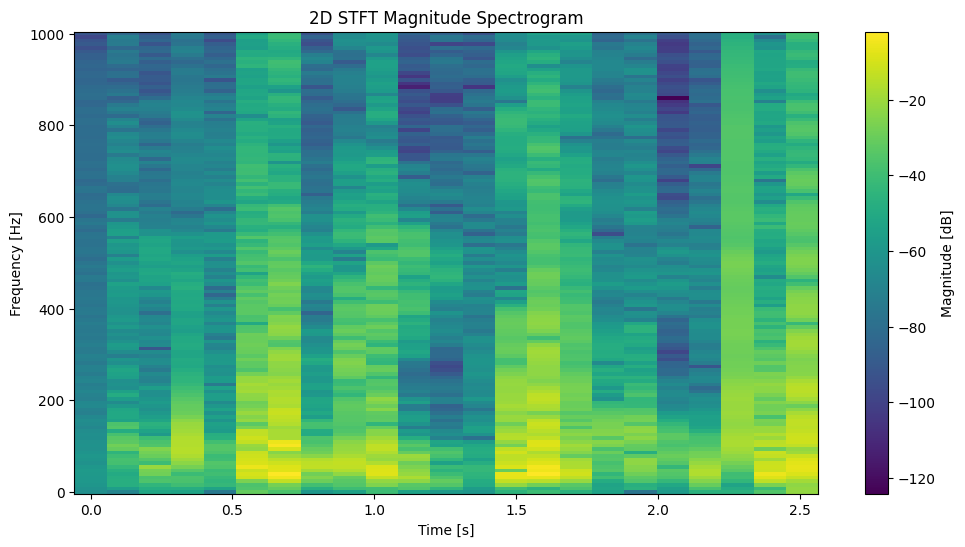

In [47]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import stft
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Function to load audio files from a specified folder
def load_audio_files(file_list, folder_path):
    audio_data = []
    record_names = []
    min_length = float('inf')
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        record_names.append(file_name)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), record_names, sr

# Function to normalize audio data using z-score
def z_score_normalize_audio_data(audio_data):
    normalized_audio = []
    for signal in audio_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        if std_val == 0:
            normalized_signal = signal - mean_val
        else:
            normalized_signal = (signal - mean_val) / std_val
        normalized_audio.append(normalized_signal)
    return np.array(normalized_audio)

# STFT parameters
nperseg = 256
noverlap = 28

# Function to compute STFT
def compute_stft(audio_data, sample_rate, nperseg=nperseg, noverlap=noverlap):
    stft_list = []
    for signal in audio_data:
        f, t, Zxx = stft(signal, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)
        stft_list.append(20 * np.log10(np.abs(Zxx)))
    stft_array = np.array(stft_list)
    return f, t, stft_array

# Function to slice the STFT and retrieve the values
def slice_stft(stft_array, frequencies, start_freq, stop_freq, increment, overlap):
    stft_slices = []
    low = start_freq
    while low < stop_freq:
        high = low + increment
        if high > stop_freq:
            high = stop_freq
        freq_mask = (frequencies >= low) & (frequencies < high)
        sliced_stft = stft_array[:, freq_mask, :]
        stft_slices.append((low, high, sliced_stft))
        low += (increment - overlap)
    return stft_slices

# Load the Excel file and select relevant columns
df = pd.read_excel('/content/PMEA_37_12_2181_OnlineAppendix.xlsx', sheet_name='SUAHSDB')
df = df[['Record name', 'Type (-1=normal 1=abnormal)']]

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/training-f'

# Get a list of all .wav files in the folder
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Filter the audio files based on record names
audio_files_filtered = [file for file in audio_files if any(record in file for record in df['Record name'])]

# Load audio data
audio_data, record_names_loaded, sample_rate = load_audio_files(audio_files_filtered, folder_path)

# Extract 2.5 seconds of audio
duration = 2.5
num_samples = int(duration * sample_rate)
audio_data = audio_data[:, :num_samples]

# Z-normalize the audio data
audio_data_norm = z_score_normalize_audio_data(audio_data)

# Compute STFT
frequencies, times, stft_array = compute_stft(audio_data_norm, sample_rate)

# Plotting the spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies,stft_array[0], shading='auto', cmap='viridis')
plt.title('2D STFT Magnitude Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude [dB]')
plt.show()

Slicing parameters:-
Starting Frequency: 0
Stop Frequency: 990
Increment: 80
Overlap: 5

Fold 1
Accuracy Score: 69.57%
Sensitivity (Recall): 0.57
Specificity: 0.75
Precision: 0.50
F1 Score: 0.53


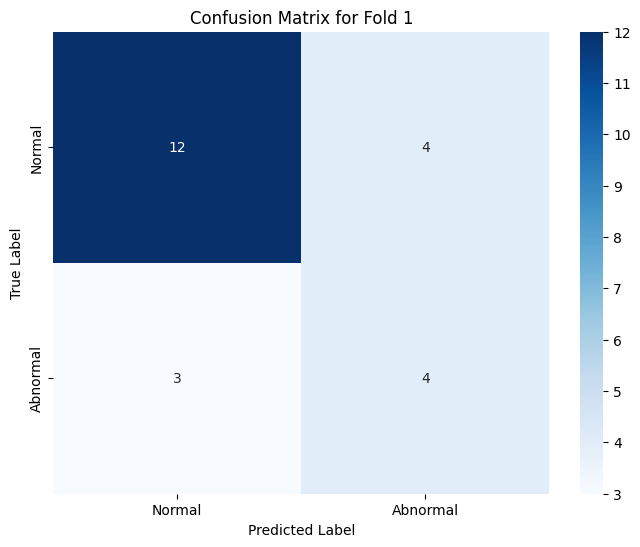


Fold 2
Accuracy Score: 69.57%
Sensitivity (Recall): 0.43
Specificity: 0.81
Precision: 0.50
F1 Score: 0.46


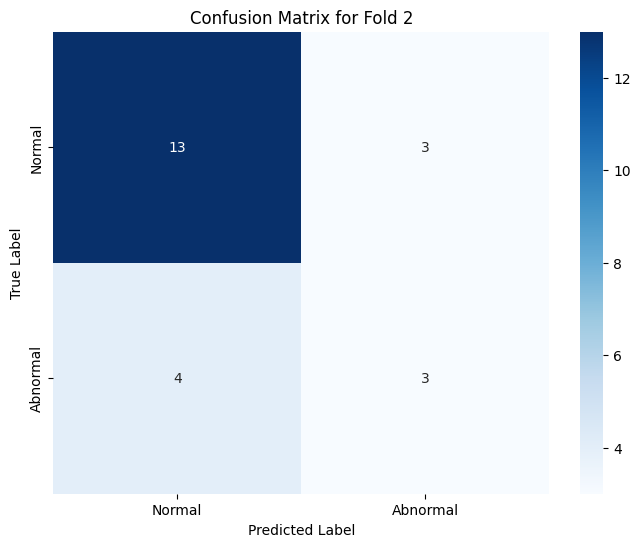


Fold 3
Accuracy Score: 73.91%
Sensitivity (Recall): 0.43
Specificity: 0.88
Precision: 0.60
F1 Score: 0.50


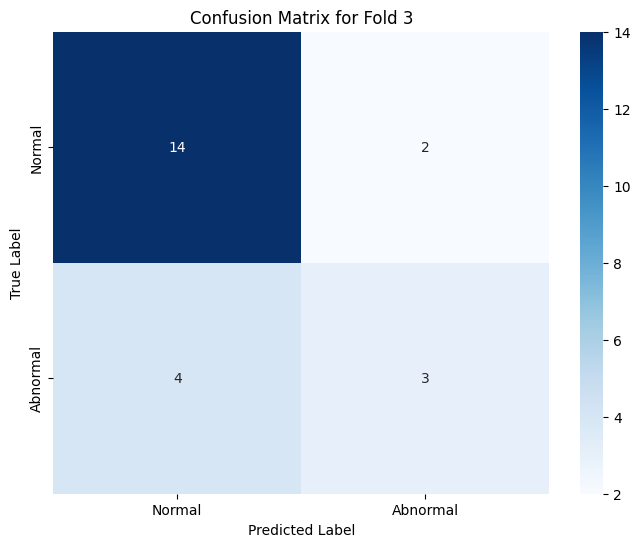


Fold 4
Accuracy Score: 69.57%
Sensitivity (Recall): 0.43
Specificity: 0.81
Precision: 0.50
F1 Score: 0.46


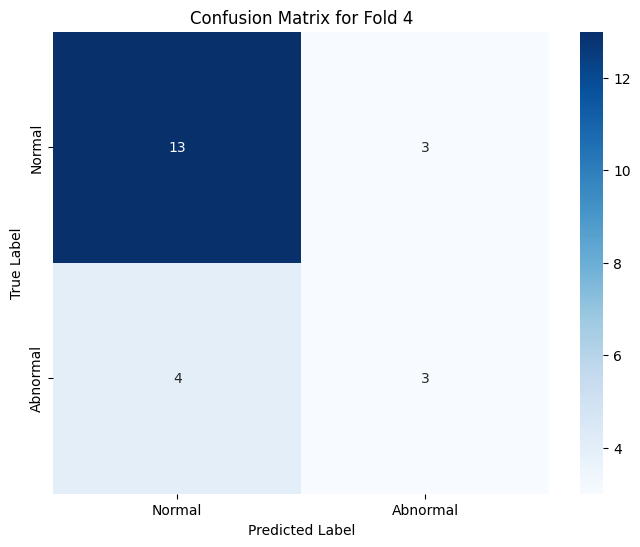


Fold 5
Accuracy Score: 90.91%
Sensitivity (Recall): 0.83
Specificity: 0.94
Precision: 0.83
F1 Score: 0.83


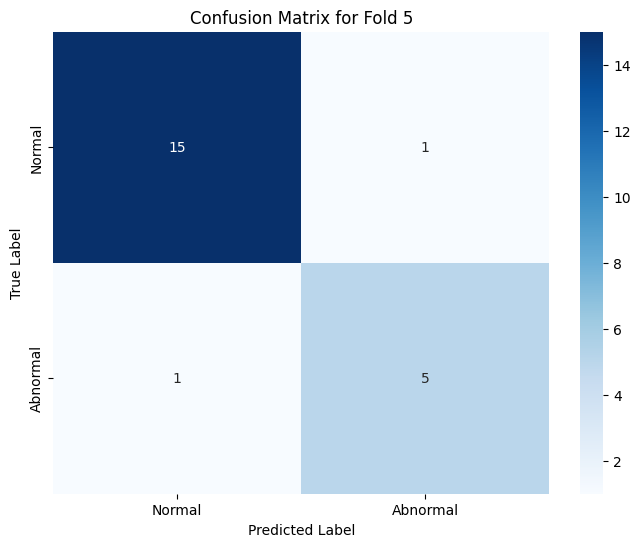


Mean Accuracy Score: 74.70%
Mean Sensitivity (Recall): 0.54
Mean Specificity: 0.84
Mean Precision: 0.59
Mean F1 Score: 0.56


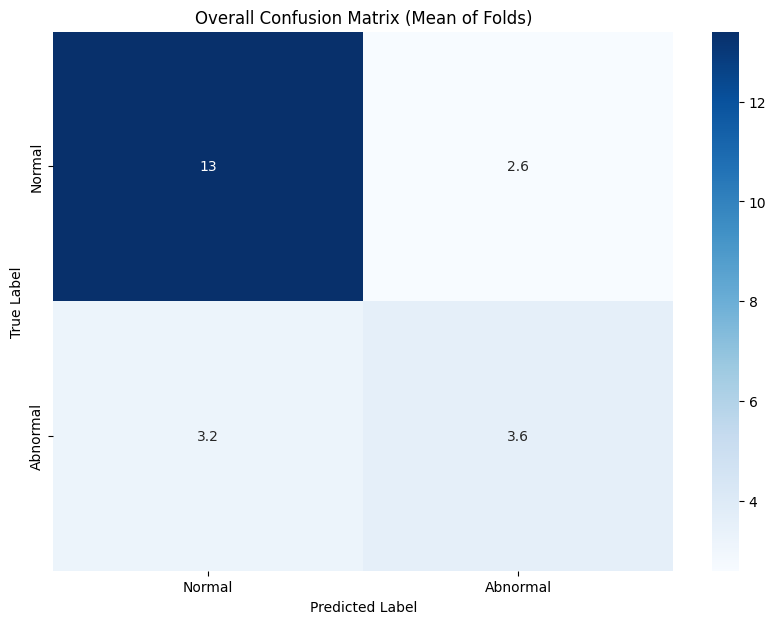

In [70]:
# Define slicing parameters
start_freq = 0
stop_freq = 990
increment = 80
overlap = 5
print("Slicing parameters:-")
print("Starting Frequency:", start_freq)
print("Stop Frequency:", stop_freq)
print("Increment:", increment)
print("Overlap:", overlap)
print()

# Slice STFT and get values
stft_slices = slice_stft(stft_array, frequencies, start_freq, stop_freq, increment, overlap)

# Prepare data for DataFrame
feature_dict = {'Record Name': record_names_loaded}

# Add STFT slices to the feature dictionary without averaging
for low, high, stft_slice in stft_slices:
    for bin_index in range(stft_slice.shape[1]):  # Each frequency bin
        for time_index in range(stft_slice.shape[2]):  # Each time bin
            feature_name = f'STFT {low}-{high} Hz Bin {bin_index + 1} Time {time_index + 1}'
            feature_dict[feature_name] = stft_slice[:, bin_index, time_index]

# Convert the feature dictionary to a DataFrame
df_features = pd.DataFrame(feature_dict)

# Sort DataFrame by 'Record Name' in ascending order and reset index
df_features_sorted = df_features.sort_values(by='Record Name').reset_index(drop=True)

# Reassign the 'Type' column to maintain its original order
df_features_sorted['Type (-1=normal 1=abnormal)'] = df['Type (-1=normal 1=abnormal)'].values

# Select all STFT features
selected_columns = [col for col in df_features_sorted.columns if col.startswith('STFT')]

# Separate features and labels
X = df_features_sorted[selected_columns].values
y = df_features_sorted['Type (-1=normal 1=abnormal)'].values

# Check for NaN or infinity values and replace them
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Initialize the scaler for feature standardization
scaler = StandardScaler()

# Fit the scaler on the data and transform
standardized_data = scaler.fit_transform(X)

# Apply k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Store results for each fold
conf_matrices = []
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1_scores = []

# Perform k-fold cross-validation manually
fold_index = 0
for train_index, test_index in kfold.split(standardized_data, y):
    X_train, X_test = standardized_data[train_index], standardized_data[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision)
    f1_scores.append(f1)

    # Plot confusion matrix for this fold
    plt.figure(figsize=(8, 6))
    print(f"Fold {fold_index + 1}")
    print(f"Accuracy Score: {accuracy * 100:.2f}%")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    sns.heatmap(conf_matrix, annot=True, fmt='.2g', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold_index + 1}')
    plt.show()
    print()

    fold_index += 1

# Calculate and display the mean metrics
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_precision = np.mean(precisions)
mean_f1_score = np.mean(f1_scores)

print(f"Mean Accuracy Score: {mean_accuracy * 100:.2f}%")
print(f"Mean Sensitivity (Recall): {mean_sensitivity:.2f}")
print(f"Mean Specificity: {mean_specificity:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean F1 Score: {mean_f1_score:.2f}")

# Display the overall confusion matrix
overall_conf_matrix = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(10, 7))
sns.heatmap(overall_conf_matrix, annot=True, fmt='.2g', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix (Mean of Folds)')
plt.show()
